<a href="https://colab.research.google.com/github/SteveChengChen/data-analysis/blob/main/STAT_5243_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar  6 22:24:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   28C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 661M/675M [00:04<00:00, 158MB/s]
100% 675M/675M [00:04<00:00, 157MB/s]


In [4]:
!unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [9]:
!mkdir /content/backup_nested_folder
!mv /content/cell_images/cell_images/* /content/backup_nested_folder
!rmdir /content/cell_images/cell_images

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score


In [6]:
print("TensorFlow version:", tf.__version__)
print("GPU device:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
train_generator = train_datagen.flow_from_directory(
    '/content/cell_images',  # updated path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)


Found 22048 images belonging to 2 classes.


In [11]:
# Define image dimensions and paths
IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32

data_dir = "./cell_images"  # path to the dataset directory containing 'Parasitized' and 'Uninfected' subfolders

# Create an ImageDataGenerator for augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,       # normalize pixel values
    rotation_range=15,       # random rotations up to 15 degrees
    width_shift_range=0.1,   # horizontal shifts
    height_shift_range=0.1,  # vertical shifts
    zoom_range=0.1,          # zoom-in up to 10%
    horizontal_flip=True,    # horizontal flip
    vertical_flip=False,     # (optional: you could use vertical_flip since cell orientation is not fixed)
    validation_split=0.2     # reserve 20% of data for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',    # two classes: binary classification
    subset='training',
    shuffle=True
)

# Validation data generator (note: we will use this as our test set for final evaluation as well)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False  # don't shuffle, so we can align predictions with labels later
)

# Class indices for reference
print("Class indices:", train_generator.class_indices)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Class indices: {'Parasitized': 0, 'Uninfected': 1}


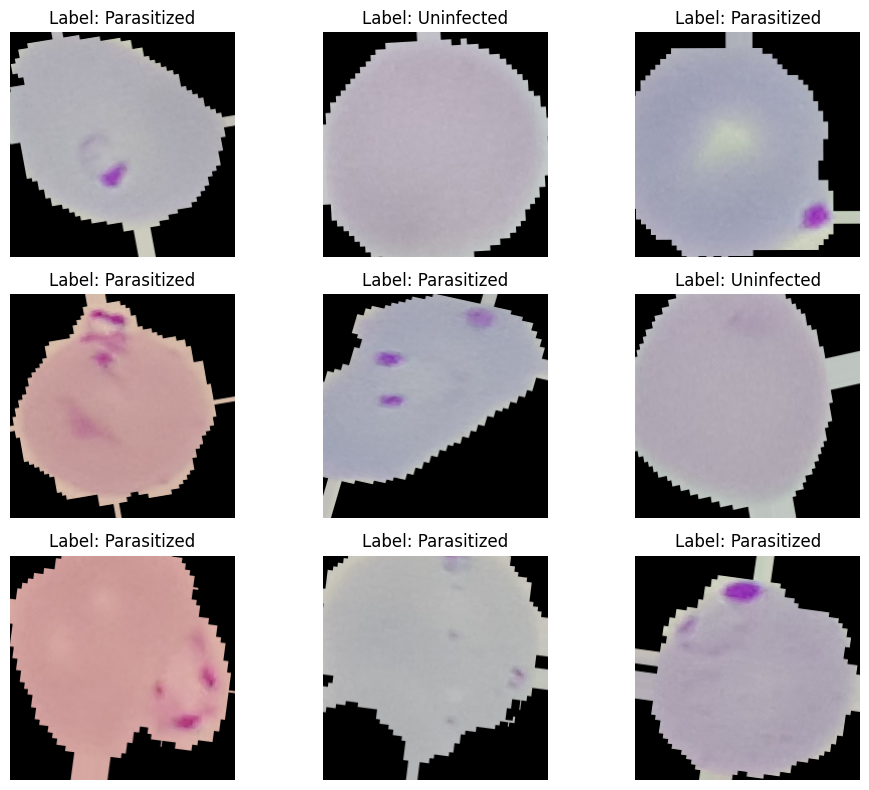

In [12]:
# Display a batch of images with their labels to verify augmentation
images, labels = next(train_generator)  # get one batch
plt.figure(figsize=(10,8))
for i in range(9):  # show 9 images
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])  # images are already rescaled to 0-1
    plt.title("Label: {}".format("Parasitized" if labels[i] == 0 else "Uninfected"))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [13]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# 1. VGG16 base + custom top layers
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_vgg.trainable = False  # freeze base
x = GlobalAveragePooling2D()(base_vgg.output)
x = Dense(128, activation='relu')(x)       # hidden dense layer (hyperparameter to tune)
x = Dropout(0.5)(x)                        # dropout for regularization (hyperparameter)
output_vgg = Dense(1, activation='sigmoid')(x)
model_vgg = Model(inputs=base_vgg.input, outputs=output_vgg)
model_vgg.compile(optimizer=Adam(learning_rate=1e-4),  # learning rate is a tunable hyperparameter
                  loss='binary_crossentropy', metrics=['accuracy'])
print("VGG16-based model built.")

# 2. ResNet50 base + custom top layers
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_resnet.trainable = False
y = GlobalAveragePooling2D()(base_resnet.output)
y = Dense(128, activation='relu')(y)
y = Dropout(0.5)(y)
output_resnet = Dense(1, activation='sigmoid')(y)
model_resnet = Model(inputs=base_resnet.input, outputs=output_resnet)
model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='binary_crossentropy', metrics=['accuracy'])
print("ResNet50-based model built.")

# 3. MobileNetV2 base + custom top layers
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_mobilenet.trainable = False
z = GlobalAveragePooling2D()(base_mobilenet.output)
z = Dense(128, activation='relu')(z)
z = Dropout(0.5)(z)
output_mobilenet = Dense(1, activation='sigmoid')(z)
model_mobilenet = Model(inputs=base_mobilenet.input, outputs=output_mobilenet)
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='binary_crossentropy', metrics=['accuracy'])
print("MobileNetV2-based model built.")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16-based model built.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50-based model built.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2-based model built.


In [14]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [17]:
import keras_tuner as kt

def build_vgg_model(hp):
    """
    Builds a transfer-learning model using the VGG16 base.
    We'll tune the number of dense units, dropout, and learning rate.
    """
    base_vgg = VGG16(weights='imagenet', include_top=False,
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Optionally, you could unfreeze top layers. For now, keep them all frozen:
    base_vgg.trainable = False

    # Pick hyperparameters
    hp_units = hp.Choice('units', values=[64, 128, 256])
    hp_dropout = hp.Choice('dropout', values=[0.3, 0.5])
    hp_learning_rate = hp.Choice('lr', values=[1e-3, 1e-4, 1e-5])

    x = GlobalAveragePooling2D()(base_vgg.output)
    x = Dense(hp_units, activation='relu')(x)
    x = Dropout(hp_dropout)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_vgg.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_resnet_model(hp):
    """
    Builds a transfer-learning model using the ResNet50 base.
    Tune hyperparameters similarly.
    """
    base_resnet = ResNet50(weights='imagenet', include_top=False,
                           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_resnet.trainable = False  # freeze entire base by default

    hp_units = hp.Choice('units', values=[64, 128, 256])
    hp_dropout = hp.Choice('dropout', values=[0.3, 0.5])
    hp_learning_rate = hp.Choice('lr', values=[1e-3, 1e-4, 1e-5])

    x = GlobalAveragePooling2D()(base_resnet.output)
    x = Dense(hp_units, activation='relu')(x)
    x = Dropout(hp_dropout)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_resnet.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_mobilenet_model(hp):
    """
    Builds a transfer-learning model using MobileNetV2 base.
    """
    base_mobilenet = MobileNetV2(weights='imagenet', include_top=False,
                                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_mobilenet.trainable = False

    hp_units = hp.Choice('units', values=[64, 128, 256])
    hp_dropout = hp.Choice('dropout', values=[0.3, 0.5])
    hp_learning_rate = hp.Choice('lr', values=[1e-3, 1e-4, 1e-5])

    x = GlobalAveragePooling2D()(base_mobilenet.output)
    x = Dense(hp_units, activation='relu')(x)
    x = Dropout(hp_dropout)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_mobilenet.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner_vgg = kt.RandomSearch(
    build_vgg_model,
    objective='val_accuracy',  # or 'val_loss'
    max_trials=10,             # increase for a more thorough search
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_vgg',
    project_name='Malaria_VGG16'
)

tuner_vgg.search(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # we can keep this small to speed up search
    verbose=1
)

# Retrieve best hyperparameters
best_hp_vgg = tuner_vgg.get_best_hyperparameters(num_trials=1)[0]
print("BEST HP for VGG16:", best_hp_vgg.values)


Trial 1 Complete [00h 23m 27s]
val_accuracy: 0.9112522602081299

Best val_accuracy So Far: 0.9112522602081299
Total elapsed time: 00h 23m 27s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
128               |128               |units
0.5               |0.5               |dropout
1e-05             |0.001             |lr

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 284s 408ms/step - accuracy: 0.5014 - loss: 0.7886 - val_accuracy: 0.6281 - val_loss: 0.6801
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 281s 408ms/step - accuracy: 0.5231 - loss: 0.7207 - val_accuracy: 0.7194 - val_loss: 0.6671
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 281s 408ms/step - accuracy: 0.5394 - loss: 0.7013 - val_accuracy: 0.7490 - val_loss: 0.6544
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 280s 407ms/step - accuracy: 0.5763 - loss: 0.6755 - val_accuracy: 0.7612 - val_loss: 0.6437
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6113 - loss: 0.6576